# Graph model development

This notebook is the first to explore the ideas of graph-based formulation of tracking data.

In [1]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models

%matplotlib notebook

Using TensorFlow backend.


## Data generation

Let's start by writing some code to generate tracks in a 2D toy detector with hits distributed in _continuous_ space as opposed to the discrete space utilized in the discrete_extraps folder.

I'll start with straight tracks without any noise, but we can add some smearing later.

For the detector, I'll start with uniform layers of fixed size and spacing.

In [2]:
# Detector config
num_det_layers = 10

# Uniform detector layers
det_r = np.arange(num_det_layers)

In [264]:
def gen_tracks(n, det_r):
    """Generate n straight tracks.
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)"""
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    slopes = (xout - xin) / (det_r.shape[0] - 1)
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """Sorts and transposes track hit coordinates.
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)"""
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

def draw_img(img, colorbar=True, title=None, xlim=None, cmap='gray_r',
             cbar_ticks=None):
    plt.imshow(img.T, origin='lower', aspect='auto',
               interpolation='none', cmap=cmap)
    if colorbar:
        plt.colorbar(ticks=cbar_ticks)
    if title is not None:
        plt.title(title)
    if xlim is not None:
        plt.xlim(xlim)

def draw_train_history(history, draw_val=False, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()

In [256]:
num_tracks = 5
x = gen_tracks(num_tracks, det_r)
img, idx = transform_hits(x)

<IPython.core.display.Javascript object>


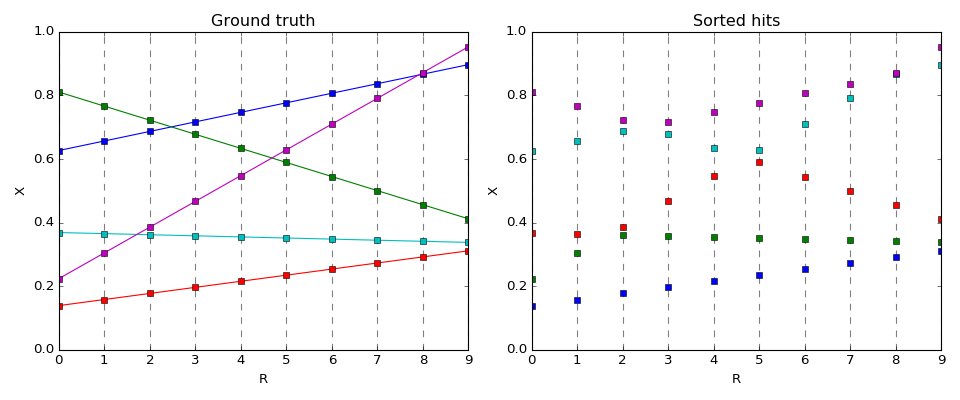

In [257]:
plt.figure(figsize=(12,5))

plt.subplot(121)
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
plt.xlim((0, num_det_layers - 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.title('Ground truth')

plt.subplot(122)
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(img.shape[1]):
    plt.plot(det_r, img.T[i], 's')
plt.xlim((0, num_det_layers - 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.title('Sorted hits')

plt.tight_layout()

<IPython.core.display.Javascript object>


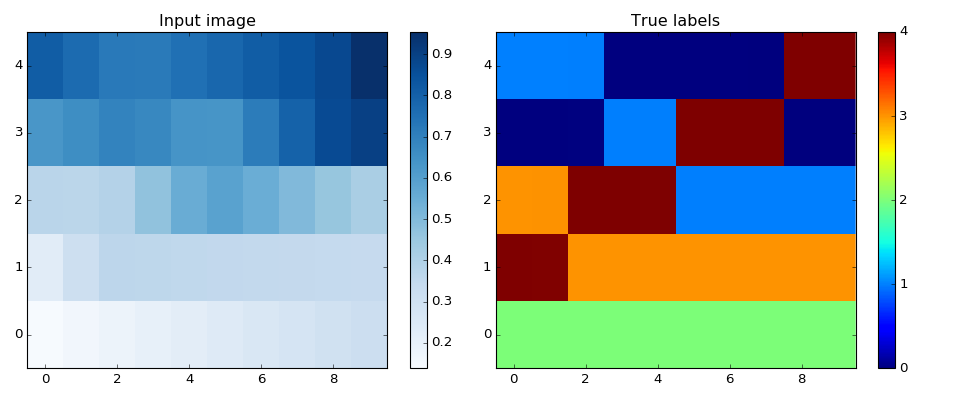

In [266]:
plt.figure(figsize=(12,5))
plt.subplot(121)
draw_img(img, title='Input image', cmap='Blues')
plt.subplot(122)
draw_img(idx, title='True labels', cmap='jet', cbar_ticks=[0, 1, 2, 3, 4])
plt.tight_layout()

Ok, next is to setup code to generate a full set of these, or a batch sample for training.

Seeded track finding model input shape is (num_event, num_chan, num_track, num_det_layer)

In [14]:
def batch_generator(num_event, #num_channel,
                    num_track, det_r, seed_size):
    """Assume one channel for now"""
    num_det_layer = det_r.shape[0]

    while True:
        # Create the empty arrays
        model_input = np.zeros((num_event, 2, num_det_layer, num_track))
        model_target = np.zeros((num_event, num_det_layer, num_track))
        
        # Loop over events
        for ievt in range(num_event):
            
            # Generate the tracks
            track_hits = gen_tracks(num_track, det_r)
            sorted_hits, sort_idx = transform_hits(track_hits)
            
            # Fill the input hit coordinates channel
            model_input[ievt, 0] = sorted_hits
                
            # Fill the model target
            itrk = 0
            track_target = (sort_idx == itrk).astype(np.float)
            model_target[ievt] = track_target
                
            # Fill the input seed; might want to set remaining values to 1
            model_input[ievt, 1, :seed_size] = track_target[:seed_size]
            
            # Loop over track channels
            #for itrk in range(num_channel):
                # Fill the model target
                #track_target = (sort_idx == itrk).astype(np.float)
                #model_target[ievt, itrk] = track_target
                # Fill the input seed; might want to set remaining values to 1
                #model_input[ievt, 1 + itrk, :seed_size] = track_target[:seed_size]

        yield model_input, model_target

<IPython.core.display.Javascript object>


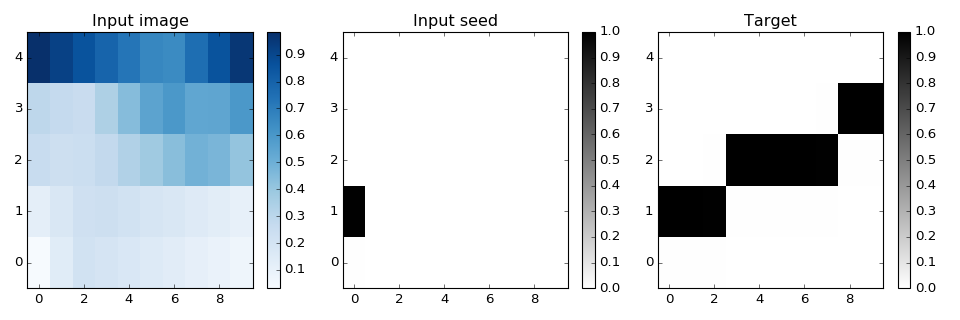

In [47]:
# Test the generator
data = batch_generator(1, 5, det_r, seed_size=1).next()
din, dout = data[0][0], data[1][0]

# Draw this event to make sure things make sense
plt.figure(figsize=(12,4))
plt.subplot(131)
draw_img(din[0], title='Input image', cmap='Blues')
plt.subplot(132)
draw_img(din[1], title='Input seed')
plt.subplot(133)
draw_img(dout, title='Target')
plt.tight_layout()

## Simple convolutional model

Now we will attempt to define a simple CNN model which operates on this data and tries to identify the target track.

In [116]:
def build_cnn(num_det_layer, num_track):
    """Assuming one output channel now for simplicity"""
    inputs = layers.Input(shape=(2, num_det_layer, num_track))
    
    # Conv layers
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(inputs)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(8, 5, 5, border_mode='same', activation='relu')(hidden)
    hidden = layers.Conv2D(1, 5, 5, border_mode='same')(hidden)

    # Output softmax
    hidden = layers.Reshape((num_det_layer, num_track))(hidden)
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [70]:
# Data config
num_tracks = 10
num_det_layers = 10
det_r = np.arange(num_det_layers)
seed_size = 3

# Training config
batch_size = 64
epoch_size = 102400
num_epoch = 50

In [ ]:
model1 = build_cnn(num_det_layer=num_det_layers, num_track=num_tracks)
model1.summary()

batcher = batch_generator(batch_size, num_track=num_tracks,
                          det_r=det_r, seed_size=seed_size)

history1 = model1.fit_generator(batcher, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 2, 10, 10)     0                                            
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 8, 10, 10)     408         input_7[0][0]                    
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 8, 10, 10)     1608        convolution2d_28[0][0]           
____________________________________________________________________________________________________
convolution2d_30 (Convolution2D) (None, 8, 10, 10)     1608        convolution2d_29[0][0]           
___________________________________________________________________________________________

In [81]:
print(history1.history['acc'][-3:])
print(history1.history['loss'][-3:])

[0.92537990808486936, 0.92595510158687833, 0.9265586197376251]
[0.17884840839076788, 0.17705720857251436, 0.17593459159601479]


<IPython.core.display.Javascript object>


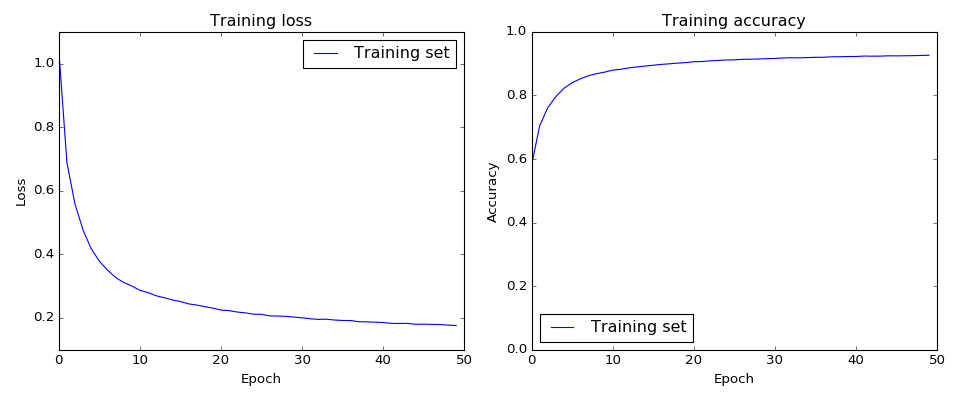

In [75]:
draw_train_history(history1)

In [ ]:
# Generate a little test set
test_input, test_target = batcher.next()
test_pred = model1.predict(test_input)

<IPython.core.display.Javascript object>


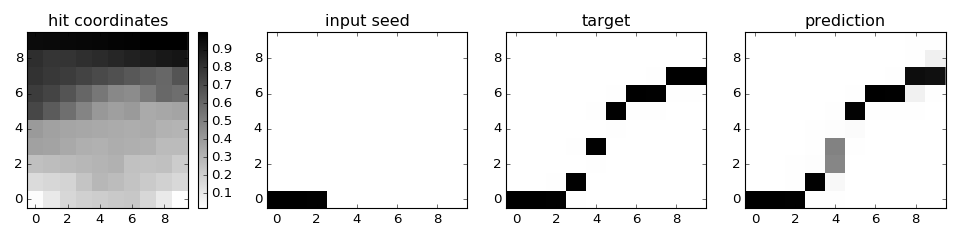

<IPython.core.display.Javascript object>


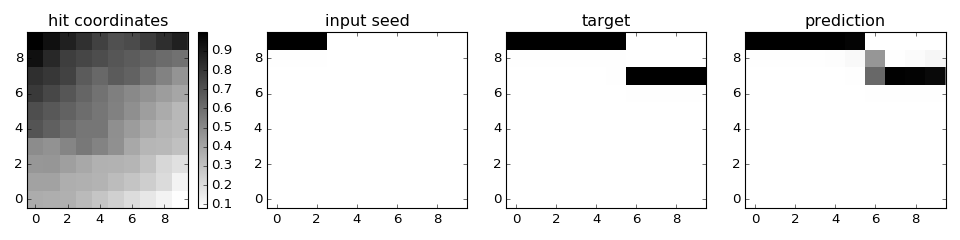

<IPython.core.display.Javascript object>


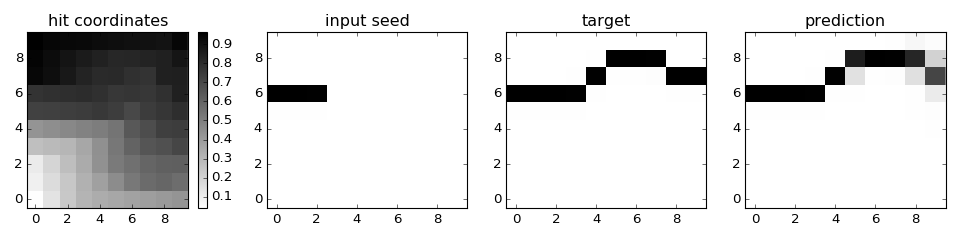

<IPython.core.display.Javascript object>


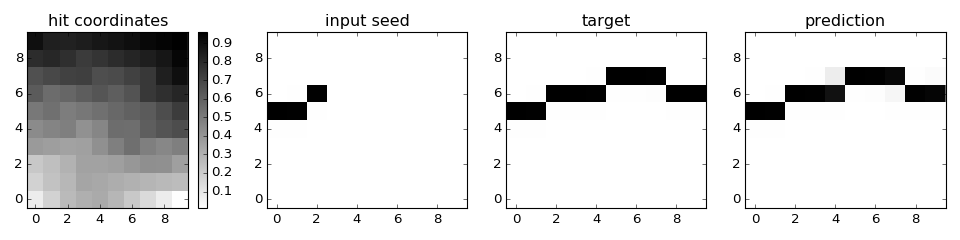

In [200]:
for i in [0, 1, 2, 3]:
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    draw_img(test_input[i][0], title='hit coordinates')
    plt.subplot(142)
    draw_img(test_input[i][1], xlim=(-0.5,num_det_layers-0.5), title='input seed', colorbar=False)
    plt.subplot(143)
    draw_img(test_target[i], colorbar=False, title='target')
    plt.subplot(144)
    draw_img(test_pred[i], colorbar=False, title='prediction')
    plt.tight_layout()

## Fully connected hit classifier

Now let's use the same data structure but use fully-connected layers to do the hit classification.

In [180]:
def build_fnn(hidden_size, num_det_layer, num_track, seed_size):
    """Assuming one output channel now for simplicity"""
    # Prepare the inputs
    graph_input = layers.Input(shape=(num_det_layer, num_track))
    seed_input = layers.Input(shape=(seed_size, num_track))
    graph_flat = layers.Flatten()(graph_input)
    seed_flat = layers.Flatten()(seed_input)
    combined_input = layers.merge([graph_flat, seed_flat], mode='concat')
    # Fully connected layers
    hidden = layers.Dense(hidden_size, activation='relu')(combined_input)
    hidden = layers.Dense(hidden_size, activation='relu')(hidden)
    hidden = layers.Dense(hidden_size, activation='relu')(hidden)
    # Fully connected layer, reshaped and softmax
    hidden = layers.Dense(num_det_layer*num_track)(hidden)
    hidden = layers.Reshape((num_det_layer, num_track))(hidden)
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    model = models.Model(input=[graph_input, seed_input], output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [181]:
def batch_generator_fc(num_event, num_track, det_r, seed_size):
    num_det_layer = det_r.shape[0]

    while True:
        # Create the empty arrays
        input_graph = np.zeros((num_event, num_det_layer, num_track))
        input_seed = np.zeros((num_event, seed_size, num_track))
        target = np.zeros((num_event, num_det_layer, num_track))
        # Loop over events
        for ievt in range(num_event):
            # Generate the tracks
            track_hits = gen_tracks(num_track, det_r)
            sorted_hits, sort_idx = transform_hits(track_hits)
            # Fill the input hit coordinates channel
            input_graph[ievt] = sorted_hits
            # Fill the model target
            itrk = 0
            track_target = (sort_idx == itrk).astype(np.float)
            target[ievt] = track_target
                
            # Fill the input seed
            input_seed[ievt] = track_target[:seed_size]

        yield [input_graph, input_seed], target

In [193]:
# Data config
num_tracks = 5
num_det_layers = 10
det_r = np.arange(num_det_layers)
seed_size = 3

# Model config
hidden_dim = 50

# Training config
batch_size = 64
epoch_size = 1024000
num_epoch = 10

In [70]:
# Data config
num_tracks = 10
num_det_layers = 10
det_r = np.arange(num_det_layers)
seed_size = 3

# Training config
batch_size = 64
epoch_size = 102400
num_epoch = 50

In [194]:
model2 = build_fnn(hidden_size=hidden_dim,
                   num_det_layer=num_det_layers,
                   num_track=num_tracks,
                   seed_size=seed_size)
model2.summary()

batcher = batch_generator_fc(batch_size, num_track=num_tracks,
                             det_r=det_r, seed_size=seed_size)

history2 = model2.fit_generator(batcher, samples_per_epoch=epoch_size, nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 10, 5)         0                                            
____________________________________________________________________________________________________
input_42 (InputLayer)            (None, 3, 5)          0                                            
____________________________________________________________________________________________________
flatten_29 (Flatten)             (None, 50)            0           input_41[0][0]                   
____________________________________________________________________________________________________
flatten_30 (Flatten)             (None, 15)            0           input_42[0][0]                   
___________________________________________________________________________________________

In [195]:
# Generate a little test set
test2_input, test2_target = batcher.next()
test2_pred = model2.predict(test2_input)

<IPython.core.display.Javascript object>


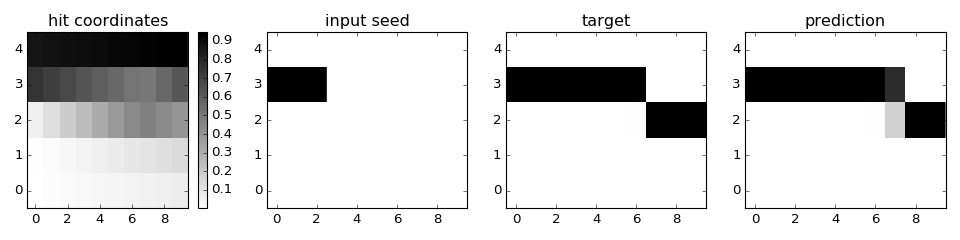

<IPython.core.display.Javascript object>


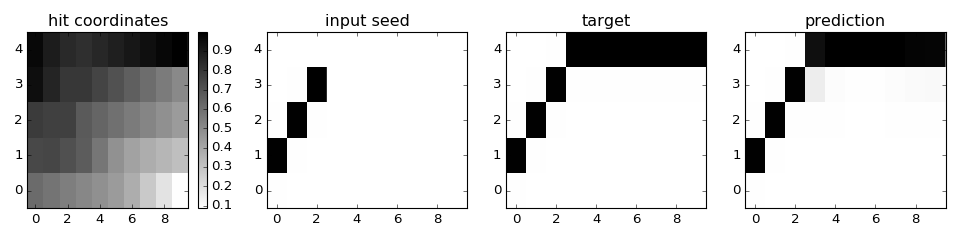

<IPython.core.display.Javascript object>


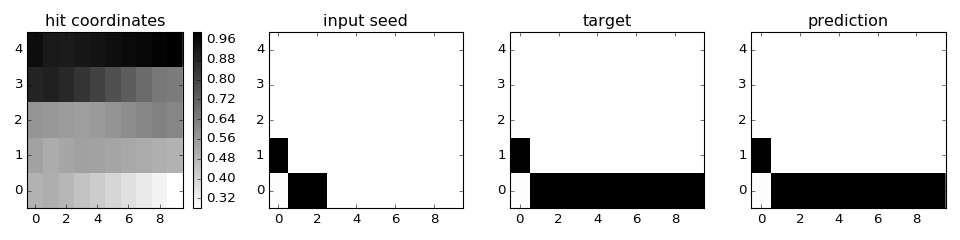

<IPython.core.display.Javascript object>


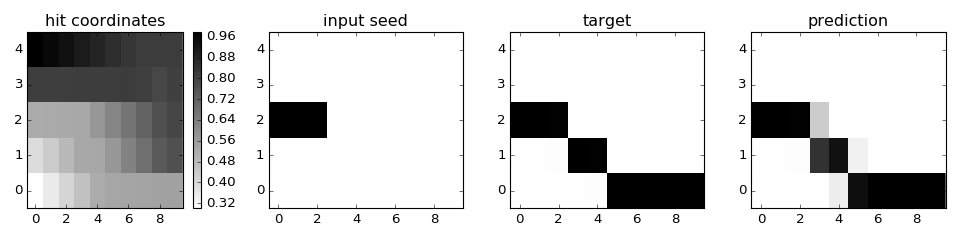

In [196]:
for i in [0, 1, 2, 3]:
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    draw_img(test2_input[0][i], title='hit coordinates')
    plt.subplot(142)
    draw_img(test2_input[1][i], xlim=(-0.5,num_det_layers-0.5), title='input seed', colorbar=False)
    plt.subplot(143)
    draw_img(test2_target[i], colorbar=False, title='target')
    plt.subplot(144)
    draw_img(test2_pred[i], colorbar=False, title='prediction')
    plt.tight_layout()

## LSTM

Let's try the LSTM architecture on this problem!

In [237]:
def build_lstm(length, dim, hidden_dim=10,
               loss='categorical_crossentropy',
               optimizer='Nadam', metrics=['accuracy']):
    """
    Build the simple LSTM model.

    This is a sequence to sequence model with the following
    architecture:
        Input -> LSTM -> Dense -> Output
    Input and output data must have shape:
        (num_batch, length, dim).
    """
    inputs = layers.Input(shape=(2, length, dim))
    hidden = layers.Permute((2, 3, 1))(inputs)
    hidden = layers.Reshape((length, dim*2))(hidden)
    hidden = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(hidden)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [251]:
# Data config
num_tracks = 5

# Model config
hidden_dim = 20

# Training config
batch_size = 64
epoch_size = 102400
num_epoch = 20

In [252]:
model3 = build_lstm(length=num_det_layers, dim=num_tracks, hidden_dim=hidden_dim)
model3.summary()

batcher3 = batch_generator(batch_size, num_track=num_tracks,
                           det_r=det_r, seed_size=seed_size)

history3 = model3.fit_generator(batcher3, samples_per_epoch=epoch_size, nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_53 (InputLayer)            (None, 2, 10, 5)      0                                            
____________________________________________________________________________________________________
permute_7 (Permute)              (None, 10, 5, 2)      0           input_53[0][0]                   
____________________________________________________________________________________________________
reshape_28 (Reshape)             (None, 10, 10)        0           permute_7[0][0]                  
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 10, 20)        2480        reshape_28[0][0]                 
___________________________________________________________________________________________

In [253]:
# Generate a little test set
test3_input, test3_target = batcher3.next()
test3_pred = model3.predict(test3_input)

<IPython.core.display.Javascript object>


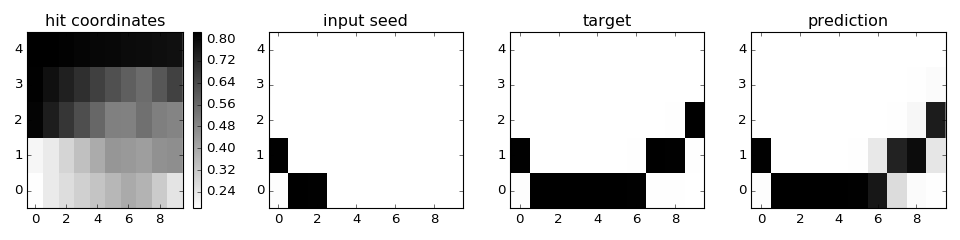

<IPython.core.display.Javascript object>


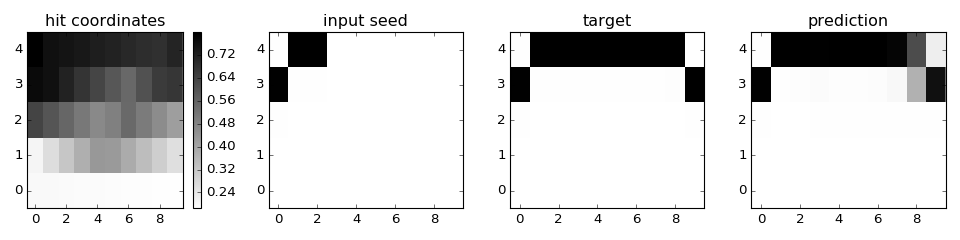

<IPython.core.display.Javascript object>


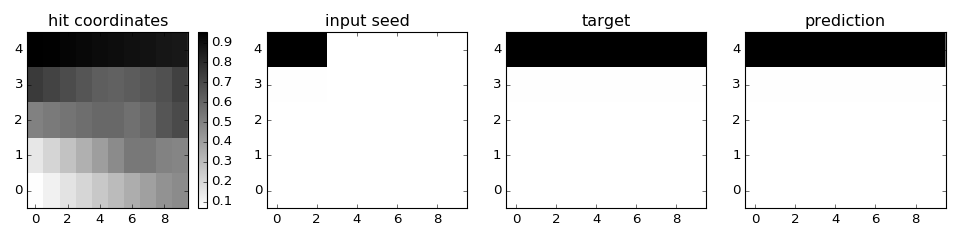

<IPython.core.display.Javascript object>


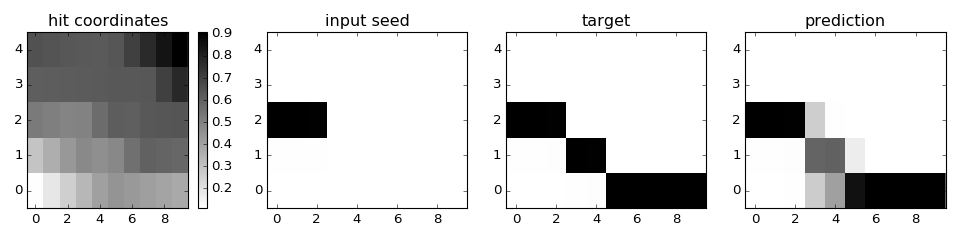

In [254]:
for i in [0, 1, 2, 3]:
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    draw_img(test3_input[i][0], title='hit coordinates')
    plt.subplot(142)
    draw_img(test3_input[i][1], xlim=(-0.5,num_det_layers-0.5), title='input seed', colorbar=False)
    plt.subplot(143)
    draw_img(test3_target[i], colorbar=False, title='target')
    plt.subplot(144)
    draw_img(test3_pred[i], colorbar=False, title='prediction')
    plt.tight_layout()

## Discussion

This idea to formulate the data this way seems to be effective. For now, conv nets seem to train better on this data structure than fully connected networks.

I haven't tried multi-track finding yet, which should probably be done.